This section defines a function that generates data the combined datasets (original and synthesis) specifying a portion and position  for cluster to represent the outliers. random seed is used in order to control the randomness of the generated data.


*   Calculates the clustered portion and position for the synthesis data in this case.
*   stacks the two datasets row-wise (vertically)

*   labels the data point from original dataset as 1 and synthesis data as 2, then stack this row-wise (vertically)   




In [235]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.stats import hypergeom
import matplotlib.pyplot as plt

In [236]:
def generate_data_with_cluster(original_size=100, synthetic_size=150, cluster_ratio=0.05, data_radius=5, cluster_radius=1, min_distance_from_origin=100, random_seed=42):
    np.random.seed(random_seed)
    original_center = np.array([0, 0])  # Center for original data
    synthetic_center = np.array([0, 0])  # Center for synthetic data

    original_data = original_center + np.random.normal(loc=0, scale=data_radius, size=(original_size, 2)) # data is shifted by the randomly generated data
    synthetic_data = synthetic_center + np.random.normal(loc=0, scale=data_radius, size=(synthetic_size, 2))
    num_clustered = int(synthetic_size * cluster_ratio)
    clustered_indices = np.random.choice(synthetic_size, num_clustered, replace=False)

    angle = np.random.uniform(0, 2 * np.pi, num_clustered)
    radius = np.full(num_clustered, min_distance_from_origin)

    x_offset = radius * np.cos(angle)
    y_offset = radius * np.sin(angle)

    synthetic_data[clustered_indices] += np.column_stack((x_offset, y_offset))
    cluster_center = np.mean(synthetic_data[clustered_indices], axis=0)

    synthetic_data[clustered_indices] = cluster_center + np.random.normal(loc=0, scale=cluster_radius, size=(num_clustered, 2))

    combined_data = np.vstack((original_data, synthetic_data))
    labels = np.concatenate((np.ones(original_size), np.full(synthetic_size, 2)))
    print(combined_data.shape)
    return combined_data, labels

The next cell defines a function to calculate the k nearest neighbors to the data points in the combined dataset and return the distances and the indices of these neighbors 

note* let the knn neighbor ignore the trivial nbd

In [237]:
def calculate_knn(combined_data, k=10):
    knn = NearestNeighbors(n_neighbors=k+1)
    knn.fit(combined_data)
    
    knn_distances, knn_indices = knn.kneighbors(combined_data)

    knn_distances = knn_distances[:, 1:]  # Exclude the first column (self distance)
    knn_indices = knn_indices[:, 1:]      # Exclude the first column (self index)

    return knn_indices, knn_distances

The function count_original_vs_synthetic_neighbors is designed to count the number of "original" and "synthetic" neighbors for each data point, based on the knn_indices (the indices of the nearest neighbors) and labels (the labels indicating whether a point is original or synthetic).


original_count = np.sum(neighbors_labels == 1):

This counts how many of the nearest neighbors have the label 1 (original points). The np.sum(neighbors_labels == 1) counts the number of True values, where the neighbor's label is 1.


synthetic_count = np.sum(neighbors_labels == 2):

This counts how many of the nearest neighbors have the label 2 (synthetic points), in the same way as for original points.

In [238]:

def count_original_vs_synthetic_neighbors(knn_indices, labels):
    counts = []  # List to store the counts of original and synthetic neighbors for each data point.
    for i in range(len(knn_indices)):  # Loop over each data point.
        neighbors_labels = labels[knn_indices[i]]  # Get the labels of the nearest neighbors for the i-th data point.
        
        original_count = np.sum(neighbors_labels == 1)  # Count how many of the neighbors are labeled as '1' (original).
        # synthetic_count = np.sum(neighbors_labels == 2)  # Count how many of the neighbors are labeled as '2' (synthetic).
        
        counts.append(original_count) #synthetic_count)  # Store the counts for this data point as a tuple.
        
        #print(f"Data point {i}: Original neighbors: {original_count}, Synthetic neighbors: {synthetic_count}")
    
    return counts  # Return the list of counts.


The function, hypergeometric_distribution, calculates the Hypergeometric distribution for two groups (original and synthetic) and returns the probabilities associated with having a specified number of original and synthetic neighbors.

The first probability (prob_original) is computed using the Hypergeometric probability mass function (PMF). It represents the probability of having exactly original_neighbors "original" neighbors out of the k nearest neighbors, assuming a total of total_points points, and N_x of them are "original"

#The PMF is a way to calculate the likelihood of getting a specified number of "successes" (here, "original" neighbors) in a fixed number of trials (k neighbors), given the total population size (total_points) and the number of "successes" in the population (N_x).



In [239]:
# Calculate the Hypergeometric Distribution 
# change the parameter to follow from thr notion page
def hypergeometric_distribution(N_x, N_y, k, original_neighbors):
    total_points = N_x + N_y
    prob_original = hypergeom.cdf(original_neighbors, total_points, N_x, k)
    #prob_synthetic = hypergeom.cdf(k - original_neighbors, total_points, N_y, k)
    return prob_original #prob_synthetic

The compute_cdf function calculates the cumulative sum of the PMF values using np.cumsum(). This returns the cumulative probability for each value in the PMF, which represents the CDF of the hypergeometric distribution.

In [240]:
"""# Compute CDF of Hypergeometric Distribution
def compute_cdf(prob_original):
    cdf = np.cumsum(prob_original)  # This is the cumulative sum of probabilities
    print(cdf[:3])
    return cdf"""

'# Compute CDF of Hypergeometric Distribution\ndef compute_cdf(prob_original):\n    cdf = np.cumsum(prob_original)  # This is the cumulative sum of probabilities\n    print(cdf[:3])\n    return cdf'

Main execution

generate the dataset

In [241]:
original_size = 1000
synthetic_size = 1500
combined_data, labels = generate_data_with_cluster(original_size=original_size, synthetic_size=synthetic_size, cluster_ratio= 0.01)

(2500, 2)


plotting the data

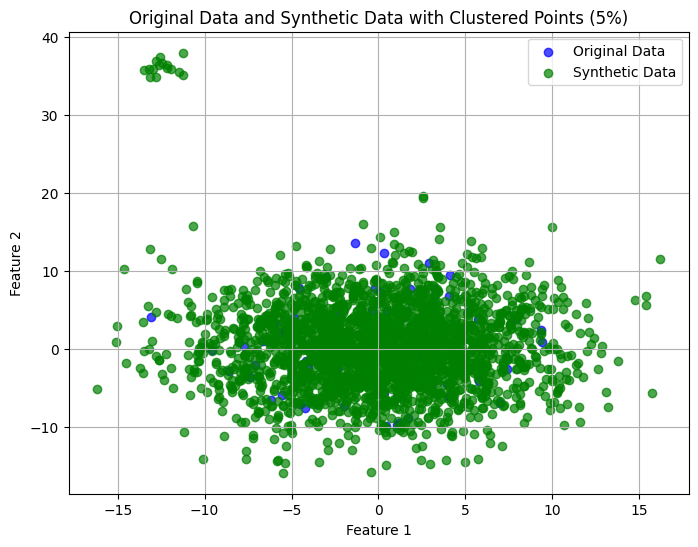

In [242]:
# Plot the data
plt.figure(figsize=(8, 6))

# Plot original data (blue)
plt.scatter(combined_data[:100, 0], combined_data[:100, 1], color='blue', label='Original Data', alpha=0.7)

# Plot synthetic data (green), including the clustered synthetic points
plt.scatter(combined_data[100:, 0], combined_data[100:, 1], color='green', label='Synthetic Data', alpha=0.7)

# Labels and title
plt.title("Original Data and Synthetic Data with Clustered Points (5%)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

find the distances and indices of the k neasrest neighbors

In [243]:
# Calculate the k-nearest neighbors for each point
k = 50
knn_indices, knn_distances = calculate_knn(combined_data, k)
print(knn_indices)
print(knn_indices.shape)

[[1716   93 2124 ... 2491 1439 1880]
 [1965 1227 1773 ... 2440  853  339]
 [1388  322  714 ... 2067 1769  947]
 ...
 [2205  888  629 ... 2000 1820  388]
 [2023 1017 1260 ... 1594  847  864]
 [ 294 1025 1865 ...  205 1975  340]]
(2500, 50)


counts in a tuple the original and synthesis neighbor of a point i in the dataset

note* counts should retuen a matrix-like shape
remedy: count only the original nbds not the syn.

In [244]:
counts = count_original_vs_synthetic_neighbors(knn_indices, labels)
print(counts)
print(len(counts))
#print(counts.shape)

[np.int64(18), np.int64(18), np.int64(20), np.int64(24), np.int64(18), np.int64(20), np.int64(16), np.int64(14), np.int64(23), np.int64(23), np.int64(21), np.int64(24), np.int64(20), np.int64(20), np.int64(14), np.int64(20), np.int64(24), np.int64(15), np.int64(15), np.int64(15), np.int64(21), np.int64(22), np.int64(17), np.int64(24), np.int64(21), np.int64(21), np.int64(19), np.int64(20), np.int64(22), np.int64(20), np.int64(13), np.int64(17), np.int64(18), np.int64(24), np.int64(21), np.int64(17), np.int64(26), np.int64(13), np.int64(26), np.int64(16), np.int64(17), np.int64(21), np.int64(20), np.int64(23), np.int64(18), np.int64(27), np.int64(19), np.int64(16), np.int64(18), np.int64(21), np.int64(17), np.int64(24), np.int64(20), np.int64(22), np.int64(21), np.int64(14), np.int64(29), np.int64(21), np.int64(27), np.int64(19), np.int64(16), np.int64(19), np.int64(25), np.int64(19), np.int64(21), np.int64(13), np.int64(22), np.int64(14), np.int64(22), np.int64(14), np.int64(21), np.in

showing the summary of counts

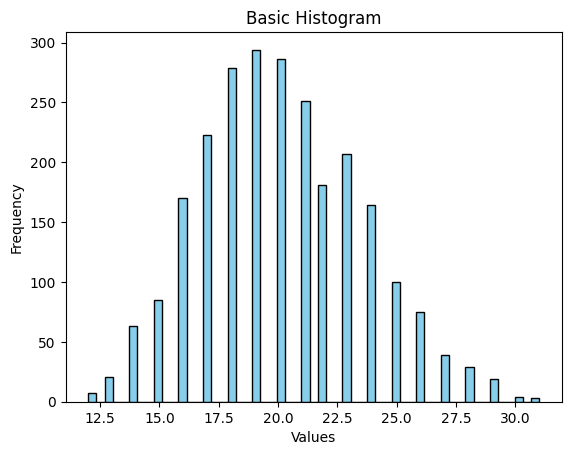

In [245]:
plt.hist(counts, bins=55, color='skyblue', edgecolor='black')
 
# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Basic Histogram')
 
# Display the plot
plt.show()

counts the number of original neighbour in the nearest neighbor

In [246]:
#original_neighbors_list = [count[0] for count in counts]

calculate the hypergeometric distribution of each points

(2500,)


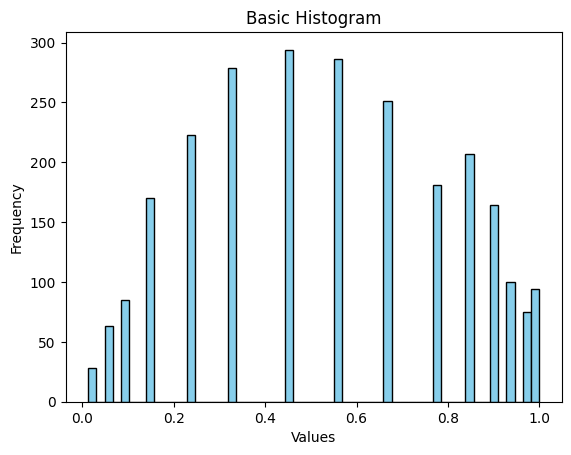

In [247]:
N_x = original_size  
N_y = synthetic_size  

# Calculate the probabilities for the original neighbors using hypergeometric distribution
prob_original = hypergeometric_distribution(N_x,N_y, k, counts)

print(prob_original.shape)

plt.hist(prob_original, bins=55, color='skyblue', edgecolor='black')
 
# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Basic Histogram')
 
# Display the plot
plt.show()

and we compute the cumulative distribution function for the prob_original (review: wrong cdf)

In [248]:
"""cdf = compute_cdf(prob_original)
len(cdf)"""

'cdf = compute_cdf(prob_original)\nlen(cdf)'

things to note:
produce a google note to display the data and its counts